In [1]:
# 1) 라이브러리
import os, re, random, math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils

SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

In [2]:
# 2) 데이터 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"

In [3]:
# 3) WISDM 파서(정규식)
def load_wisdm_regex(path):
    pat = re.compile(
        r'^\s*(\d+)\s*,\s*([A-Za-z_]+)\s*,\s*(\d+)\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*'
        r'([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*;?\s*$'
    )
    rows, skipped = [], 0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.match(line)
            if not m: skipped += 1; continue
            rows.append((
                int(m.group(1)), m.group(2), int(m.group(3)),
                float(m.group(4)), float(m.group(5)), float(m.group(6))
            ))
    df = pd.DataFrame(rows, columns=["user","activity","timestamp","x","y","z"])
    print(f"[INFO] Parsed {len(df):,} rows. Skipped {skipped:,} malformed lines.")
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

df = load_wisdm_regex(DATA_PATH)
print(df.head(), df.shape)
print(df["activity"].value_counts())


[INFO] Parsed 1,086,465 rows. Skipped 11,745 malformed lines.
   user activity  timestamp    x    y    z
0    32  Jogging          0  0.0  0.0  0.0
1    32  Jogging          0  0.0  0.0  0.0
2    32  Jogging          0  0.0  0.0  0.0
3    32  Jogging          0  0.0  0.0  0.0
4    32  Jogging          0  0.0  0.0  0.0 (1086465, 6)
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


In [4]:
# 4) 라벨 인코딩
le = LabelEncoder()
df["label"] = le.fit_transform(df["activity"])
class_names = list(le.classes_)
print("Label mapping:", {cls: int(lab) for cls, lab in zip(class_names, le.transform(class_names))})

Label mapping: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}


In [5]:
# 5) 슬라이딩 윈도우(유저/액티비티 경계 보존)
feature_cols = ["x","y","z"]
WINDOW_SIZE = 200
STEP = 100

def _segment_one_run(sub_df, window_size, step, feature_cols, label_col, num_classes=None):
    data = sub_df[feature_cols].to_numpy(dtype=np.float32)   # (L, C)
    labels = sub_df[label_col].to_numpy()
    segs, labs = [], []
    L = len(sub_df)
    for start in range(0, L - window_size + 1, step):
        end = start + window_size
        segs.append(data[start:end])
        if (num_classes is not None) and np.issubdtype(labels.dtype, np.integer):
            labs.append(np.bincount(labels[start:end], minlength=num_classes).argmax())
        else:
            codes, uniques = pd.factorize(labels[start:end], sort=False)
            labs.append(uniques[np.bincount(codes).argmax()])
    return segs, labs

def create_windows(df, window_size=200, step=100, feature_cols=("x","y","z"), label_col="label", num_classes=None):
    feature_cols = list(feature_cols)
    segments, labels = [], []
    user_groups = df.groupby("user", sort=False) if "user" in df.columns else [(None, df)]
    for _, df_u in user_groups:
        change = df_u["activity"].ne(df_u["activity"].shift()).to_numpy()
        starts = np.flatnonzero(change) if change.any() else np.array([0], dtype=int)
        ends = np.r_[starts[1:], len(df_u)]
        for s, e in zip(starts, ends):
            sub = df_u.iloc[s:e]
            if len(sub) < window_size: continue
            segs, labs = _segment_one_run(sub, window_size, step, feature_cols, label_col, num_classes)
            segments.extend(segs); labels.extend(labs)
    X = np.array(segments, dtype=np.float32) if segments else np.empty((0, window_size, len(feature_cols)), np.float32)
    y = np.array(labels)
    return X, y


In [6]:
# 6) 유저 기준 분할
assert "user" in df.columns
train_users = set([u for u in np.unique(df["user"]) if u <= 27])
test_users  = set([u for u in np.unique(df["user"]) if u >= 28])

df_train_full = df[df["user"].isin(train_users)].copy()
df_test       = df[df["user"].isin(test_users)].copy()

# 검증 유저 홀드아웃
rng = np.random.default_rng(SEED)
train_user_list = sorted(list(train_users))
n_val_users = max(1, int(len(train_user_list)*0.2))
val_users = set(rng.choice(train_user_list, size=n_val_users, replace=False))
tr_users  = train_users - val_users

df_train = df_train_full[df_train_full["user"].isin(tr_users)].copy()
df_val   = df_train_full[df_train_full["user"].isin(val_users)].copy()

print("train users:", sorted(df_train["user"].unique()))
print("val   users:", sorted(df_val["user"].unique()))
print("test  users:", sorted(df_test["user"].unique()))

# train-only 스케일링 (xyz만)
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_val[feature_cols]   = scaler.transform(df_val[feature_cols])
df_test[feature_cols]  = scaler.transform(df_test[feature_cols])

# 세트별 윈도우링
n_cls = len(np.unique(df["label"]))
X_train, y_train = create_windows(df_train, WINDOW_SIZE, STEP, feature_cols, "label", n_cls)
X_val,   y_val   = create_windows(df_val,   WINDOW_SIZE, STEP, feature_cols, "label", n_cls)
X_test,  y_test  = create_windows(df_test,  WINDOW_SIZE, STEP, feature_cols, "label", n_cls)

num_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2])

y_train_cat = utils.to_categorical(y_train, num_classes)
y_val_cat   = utils.to_categorical(y_val,   num_classes)
y_test_cat  = utils.to_categorical(y_test,  num_classes)

print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


train users: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)]
val   users: [np.int64(3), np.int64(12), np.int64(17), np.int64(19), np.int64(27)]
test  users: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
X_train: (5939, 200, 3) X_val: (1596, 200, 3) X_test: (2679, 200, 3)


In [8]:
# 8) 3D 회전 + 노이즈/스케일 증강
def _rand_rot_matrix():
    a,b,c = np.random.uniform(0, 2*np.pi, size=3)
    Rx = np.array([[1,0,0],[0,np.cos(a),-np.sin(a)],[0,np.sin(a),np.cos(a)]], dtype=np.float32)
    Ry = np.array([[np.cos(b),0,np.sin(b)],[0,1,0],[-np.sin(b),0,np.cos(b)]], dtype=np.float32)
    Rz = np.array([[np.cos(c),-np.sin(c),0],[np.sin(c),np.cos(c),0],[0,0,1]], dtype=np.float32)
    return (Rz @ Ry @ Rx).astype(np.float32)

def rotate_subset(X, y, ratio=0.6, xyz_idx=(0,1,2)):
    n = len(X); m = int(n * ratio)
    idx = np.random.choice(n, size=m, replace=False)
    Xa = X[idx].copy(); ya = y[idx].copy()
    for i in range(m):
        R = _rand_rot_matrix()
        # Apply rotation to each time step
        for t in range(Xa.shape[1]):
            Xa[i, t, list(xyz_idx)] = Xa[i, t, list(xyz_idx)] @ R.T
    return Xa, ya

def jitter_scale(X, noise_std=0.01, scale_std=0.10):
    Xn = X + np.random.normal(0, noise_std, X.shape).astype(np.float32)
    s  = np.random.normal(1.0, scale_std, size=(X.shape[0],1,1)).astype(np.float32)
    return Xn * s

Xr, yr = rotate_subset(X_train, y_train, ratio=0.6, xyz_idx=(0,1,2))
Xj     = jitter_scale(Xr, noise_std=0.01, scale_std=0.10)

X_train = np.concatenate([X_train, Xr, Xj], axis=0)
y_train = np.concatenate([y_train, yr, yr], axis=0)

# 셔플, 원-핫 갱신
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]; y_train = y_train[perm]
y_train_cat = utils.to_categorical(y_train, num_classes)

print("After aug:", X_train.shape, np.bincount(y_train, minlength=num_classes))

After aug: (13065, 200, 3) [ 969 4311  688  478 1341 5278]


## TimeNorm
 - 한 윈도우(시계열 조각) 안에서, 채널별로 시간축 기준 평균을 0, 표준편차를 1로 맞춰 주는 정규화 레이어
- 사용자·부착 위치·센서 편차로 인한 도메인 갭 완화
- 학습 초반 val loss 튐 현상 감소, 일반화↑
- 배치 크기 변화에 덜 민감(추론 시 러닝 통계가 필요 없음)

In [9]:
# 9) TimeNorm + 1D-CNN
class TimeNorm(layers.Layer):
    def __init__(self, eps=1e-5, **kw): super().__init__(**kw); self.eps = eps
    def call(self, x):
        mu = tf.reduce_mean(x, axis=1, keepdims=True)                 # (N,1,C)
        sd = tf.math.reduce_std(x, axis=1, keepdims=True) + self.eps
        return (x - mu) / sd

def build_cnn(input_shape, num_classes,
              label_smoothing=0.05, lr=1e-3, wd=1e-4):
    inp = layers.Input(shape=input_shape)
    x = TimeNorm()(inp)  # 입력단 정규화

    x = layers.Conv1D(64, 7, padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Conv1D(128, 5, padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.SpatialDropout1D(0.3)(x)

    x = layers.Conv1D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    gap = layers.GlobalAveragePooling1D()(x)
    gmp = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([gap, gmp])
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["accuracy"]
    )
    return model

model = build_cnn(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_norm           │ (None, 200, 3)    │          0 │ input_layer[0][0] │
│ (TimeNorm)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 200, 64)   │      1,408 │ time_norm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 200, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 100, 64)   │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 100, 64)   │          0 │ max_pooling1d[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     41,088 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 50, 128)   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 50, 128)   │          0 │ max_pooling1d_1[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 256)   │     98,560 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 50, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ re_lu_2[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ concatenate[0][0

 Total params: 145,926 (570.02 KB)

 Trainable params: 145,030 (566.52 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# 10) 학습
# 클래스 가중치(학습 세트 기준)
cc = np.bincount(y_train, minlength=num_classes); total = cc.sum()
class_weight = {i: float(total/(num_classes*max(1,cc[i]))) for i in range(num_classes)}
print("class_weight:", class_weight)

EPOCHS = 25
es  = callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss")
rlr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5, monitor="val_loss", verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=256,
    class_weight=class_weight,
    callbacks=[es, rlr],
    verbose=1
)


class_weight: {0: 2.2471620227038183, 1: 0.5051032243099048, 2: 3.164970930232558, 3: 4.555439330543933, 4: 1.6237882177479492, 5: 0.4125615763546798}
Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 616ms/step - accuracy: 0.2321 - loss: 2.6329 - val_accuracy: 0.5520 - val_loss: 1.4509 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.4269 - loss: 1.7704 - val_accuracy: 0.5482 - val_loss: 1.2736 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - accuracy: 0.5286 - loss: 1.4837 - val_accuracy: 0.6084 - val_loss: 1.1842 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - accuracy: 0.5918 - loss: 1.3335 - val_accuracy: 0.6310 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 594ms/step - accuracy: 0.6339 - loss: 1.1924 - val_accuracy: 0.6610 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 551ms/step - accuracy: 0.6834 - loss: 1.12

In [11]:
# 11) 평가
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"[TEST] loss={test_loss:.4f} acc={test_acc:.4f}")

y_pred = model.predict(X_test, verbose=0).argmax(axis=1)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Macro F1:", round(f1_score(y_test, y_pred, average="macro"), 4),
      "/ Weighted F1:", round(f1_score(y_test, y_pred, average="weighted"), 4))

[TEST] loss=0.6299 acc=0.8537

=== Classification Report ===
              precision    recall  f1-score   support

  Downstairs       0.65      0.67      0.66       247
     Jogging       1.00      0.94      0.96       760
     Sitting       0.64      0.59      0.61       168
    Standing       0.56      0.67      0.61       150
    Upstairs       0.92      0.64      0.76       279
     Walking       0.87      0.96      0.91      1075

    accuracy                           0.85      2679
   macro avg       0.77      0.74      0.75      2679
weighted avg       0.86      0.85      0.85      2679

Macro F1: 0.7526 / Weighted F1: 0.8528


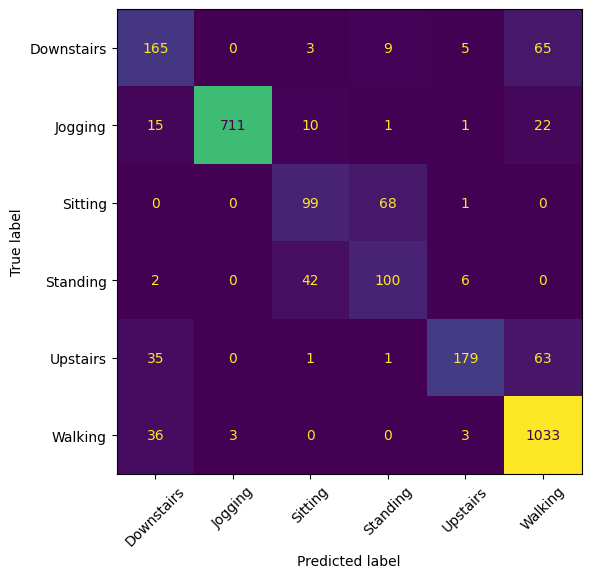

In [12]:
# 12) 혼동행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout(); plt.show()

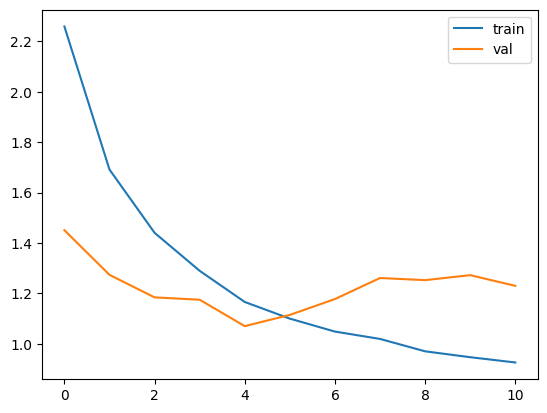

In [13]:

# 13) 학습곡선
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val"); plt.legend(); plt.show()